In [17]:
#import libraries 
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from glob import glob
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [3]:
#extract data
data = pd.read_csv("animal-clef-2025/metadata.csv")
data.head()

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025


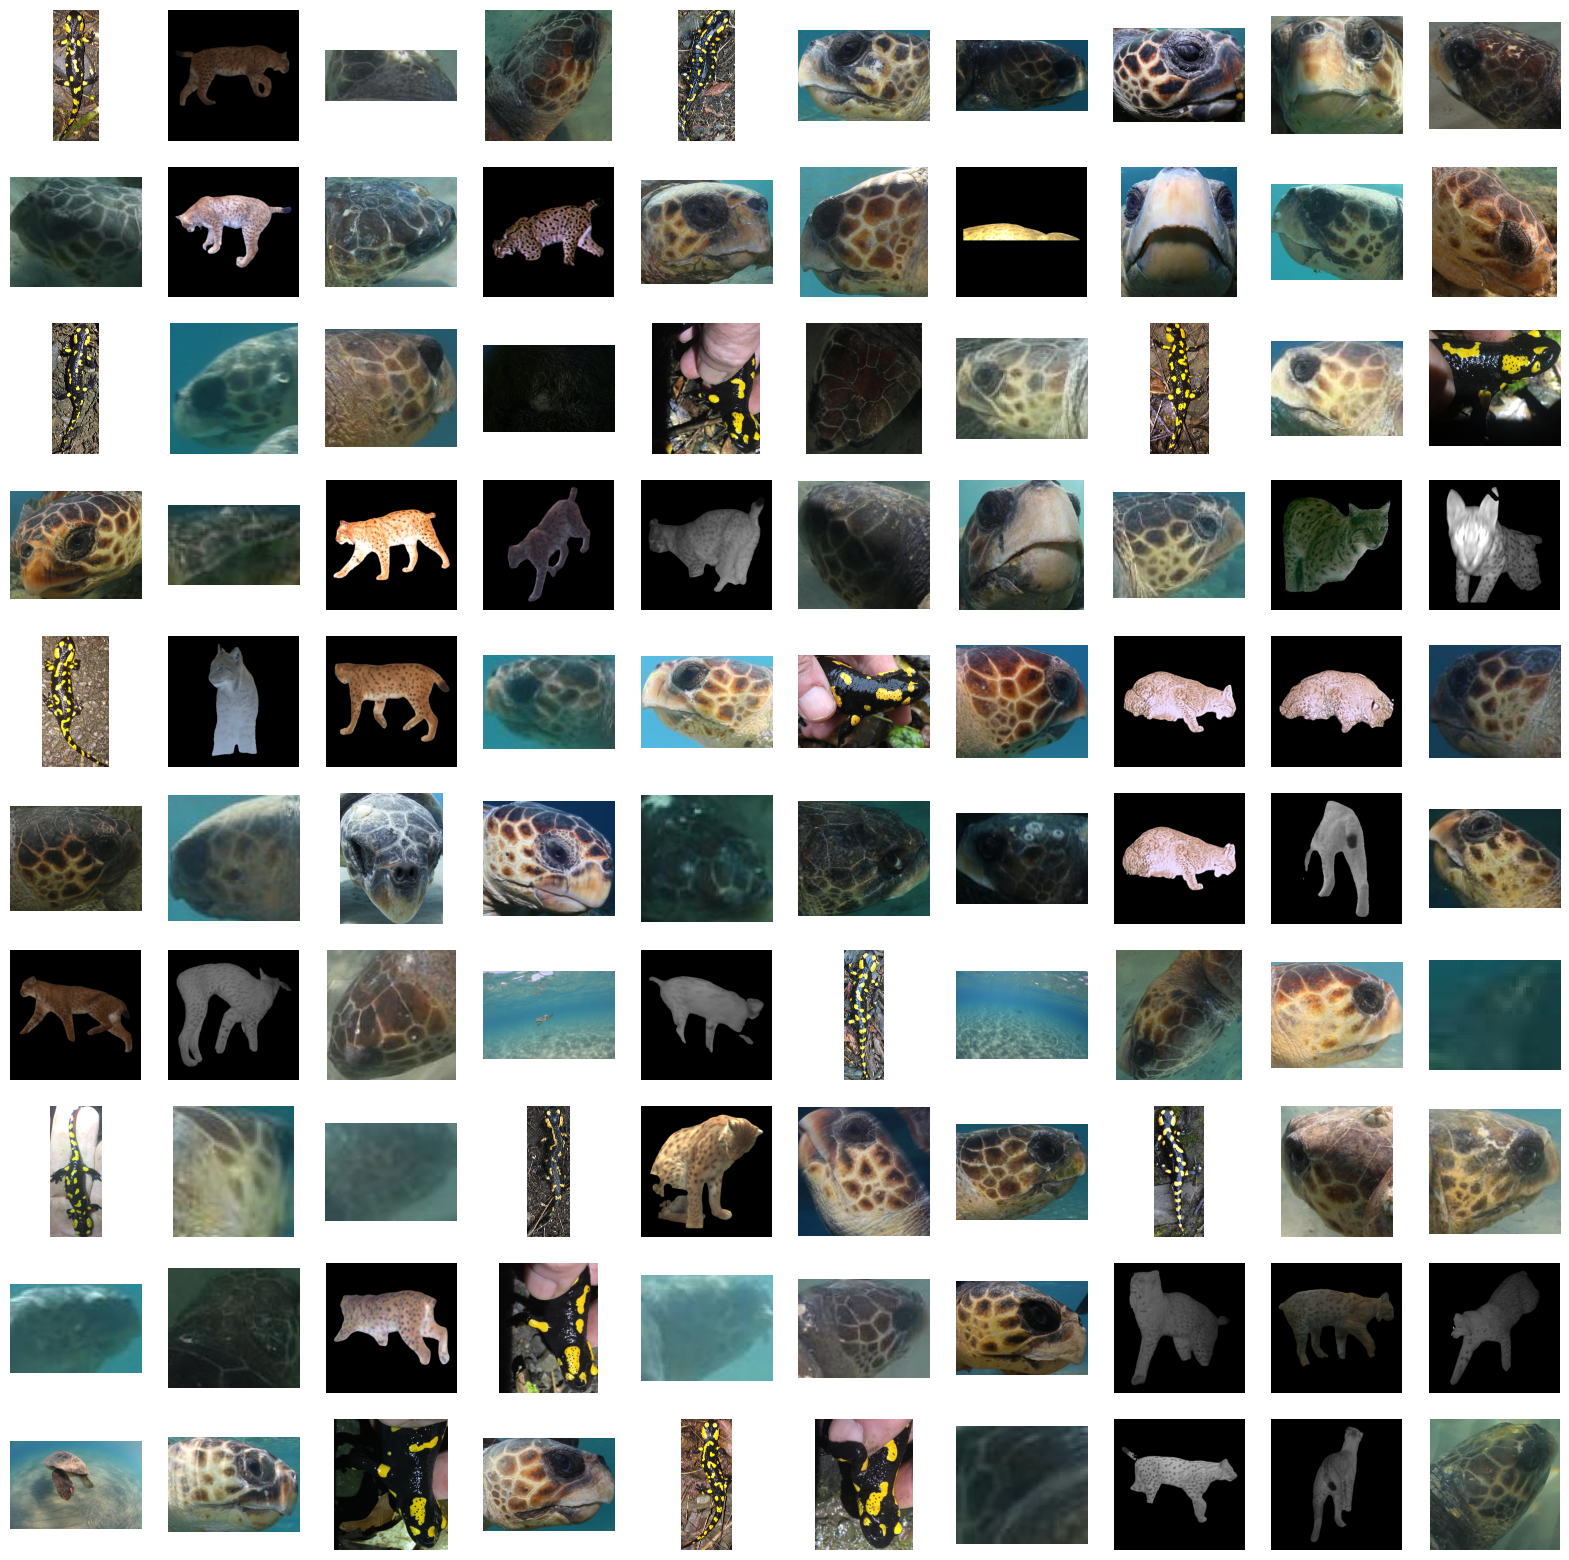

In [30]:
path = "animal-clef-2025/" + data['path'].sample(100,random_state = 21).values
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for k,j in enumerate(range(10)):
        img = Image.open(path[i*10+j])
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
plt.show()

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory("animal-clef-2025/train/",validation_split = .2,subset = "training", seed = 21, image_size=(100,100),batch_size=128)
val_ds = tf.keras.utils.image_dataset_from_directory("animal-clef-2025/train/",validation_split = .2, subset = "validation", seed = 21, image_size=(100,100),batch_size=128)

Found 13074 files belonging to 3 classes.
Using 10460 files for training.
Found 13074 files belonging to 3 classes.
Using 2614 files for validation.


In [32]:
class_names = train_ds.class_names
k = len(class_names)

In [33]:
image_size = [100, 100]
AUTOTUNE = tf.data.AUTOTUNE
train_ds_unshuffled = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
rs = ResNet50(weights='imagenet', include_top=False, input_shape= image_size + [3])

In [35]:
# Freeze the base model
for layer in rs.layers:
    layer.trainable = False

In [36]:
i = Input(shape=image_size + [3])
x = preprocess_input(i)
#x = data_augmentation(x)
x = rs(x)
x = Flatten()(x)
x = Dense(k, activation='relu')(x)
model = Model(inputs = i,outputs =  x)

In [37]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 100, 100)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 100, 100)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 100, 100)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 100, 100,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 100,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32768)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │     98,307 │ flatten_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,686,019 (90.35 MB)

 Trainable params: 98,307 (384.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [39]:
history = model.fit(train_ds, epochs=12, validation_data=val_ds)

Epoch 1/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.8233 - loss: 0.9687 - val_accuracy: 0.8864 - val_loss: 0.1694
Epoch 2/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8582 - loss: 0.1954 - val_accuracy: 0.7674 - val_loss: 0.2929
Epoch 3/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7631 - loss: 0.2925 - val_accuracy: 0.7666 - val_loss: 0.2862
Epoch 4/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7637 - loss: 0.2847 - val_accuracy: 0.7682 - val_loss: 0.2795
Epoch 5/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7643 - loss: 0.2788 - val_accuracy: 0.7693 - val_loss: 0.2757
Epoch 6/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7669 - loss: 0.3166 - val_accuracy: 0.7934 - val_loss: 0.2307
Epoch 7/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7901 - loss: 0.2331 - val_accuracy: 0.8550 - val_loss: 0.1631
Epoch 8/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8465 - loss: 0.1712 - val_accuracy: 0.8585 - v

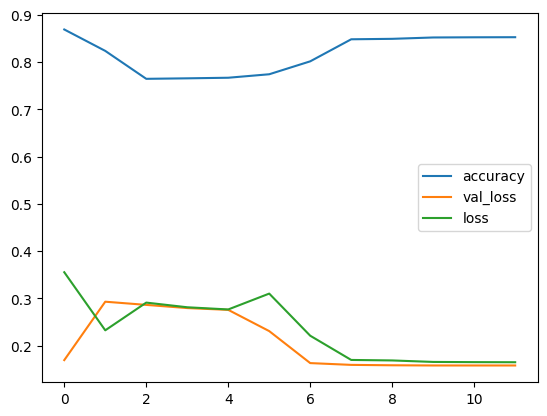

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history["val_loss"],label ='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()

In [41]:
def get_confusion_matrix(dataset):
    predictions = model.predict(dataset).argmax(axis=1)
    targets = dataset.map(lambda x, y: y).unbatch()
    targets = np.array([y.numpy() for x, y in targets])
    return confusion_matrix(targets,predictions)

In [23]:
cm = get_confusion_matrix(train_ds_unshuffled)
cm

103/103 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step


TypeError: Cannot iterate over a scalar tensor.

In [ ]:
validation_cm = get_confusion_matrix(val_ds)
validation_cm

17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)

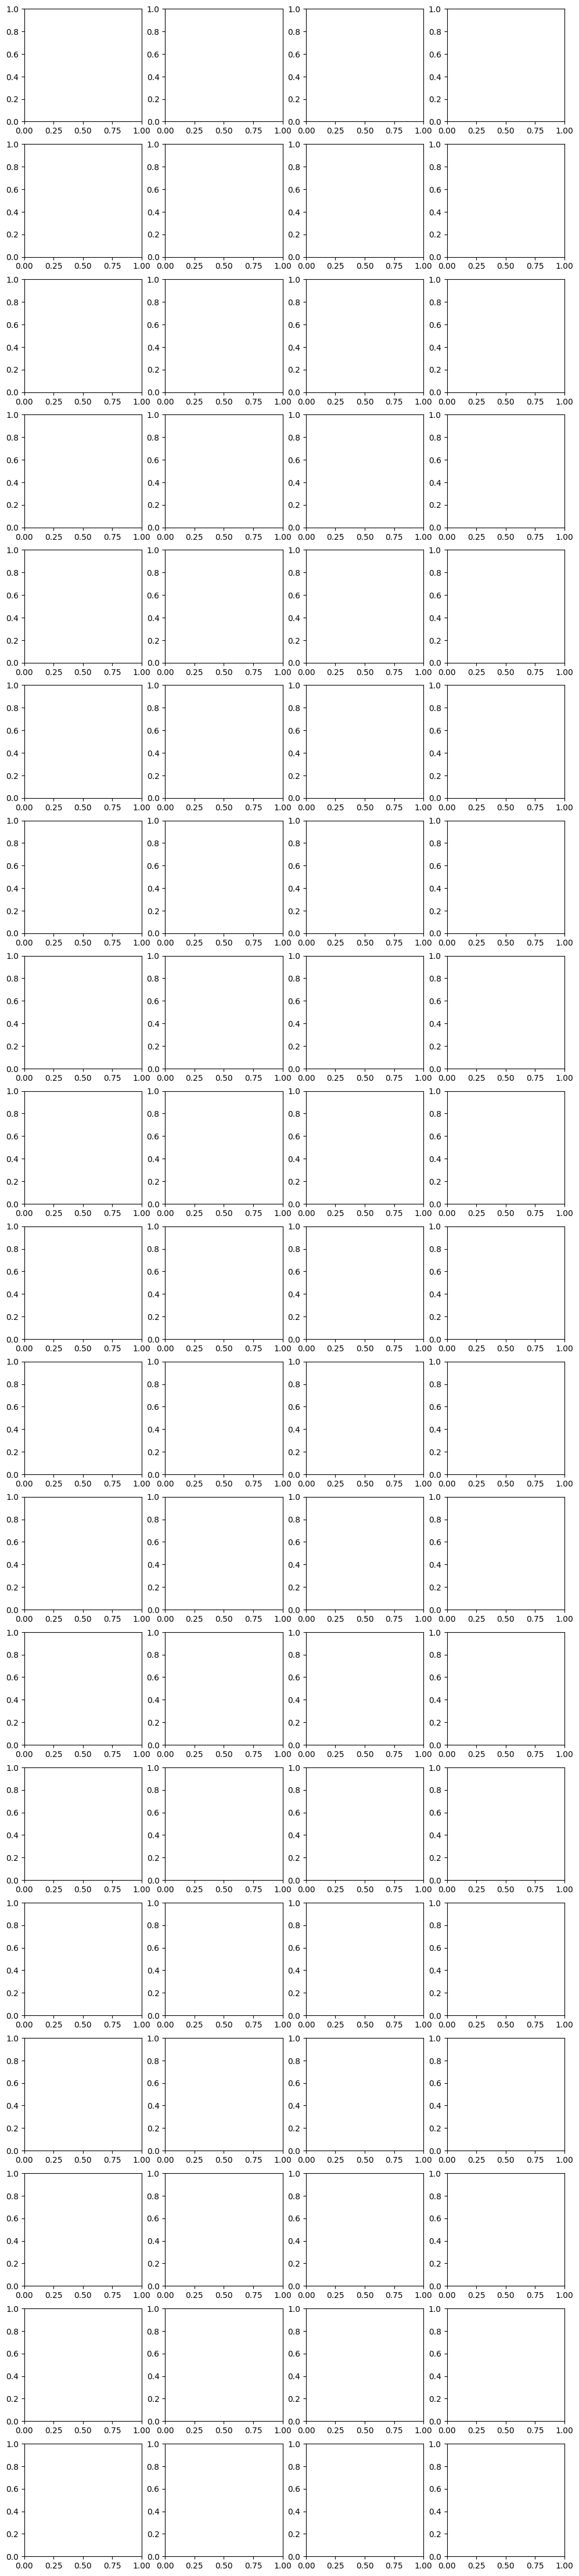

In [26]:
predictions = model.predict(val_ds)
threshold = .8
pred_idxs = np.argmax(predictions, axis=1)
pred_scores = np.max(predictions,axis = 1)
in_database = []
outside_database = []
for idx, score in zip(pred_idxs, pred_scores):
    if score > threshold:
        in_database.append(idx)
    else:
        outside_database.append(idx)



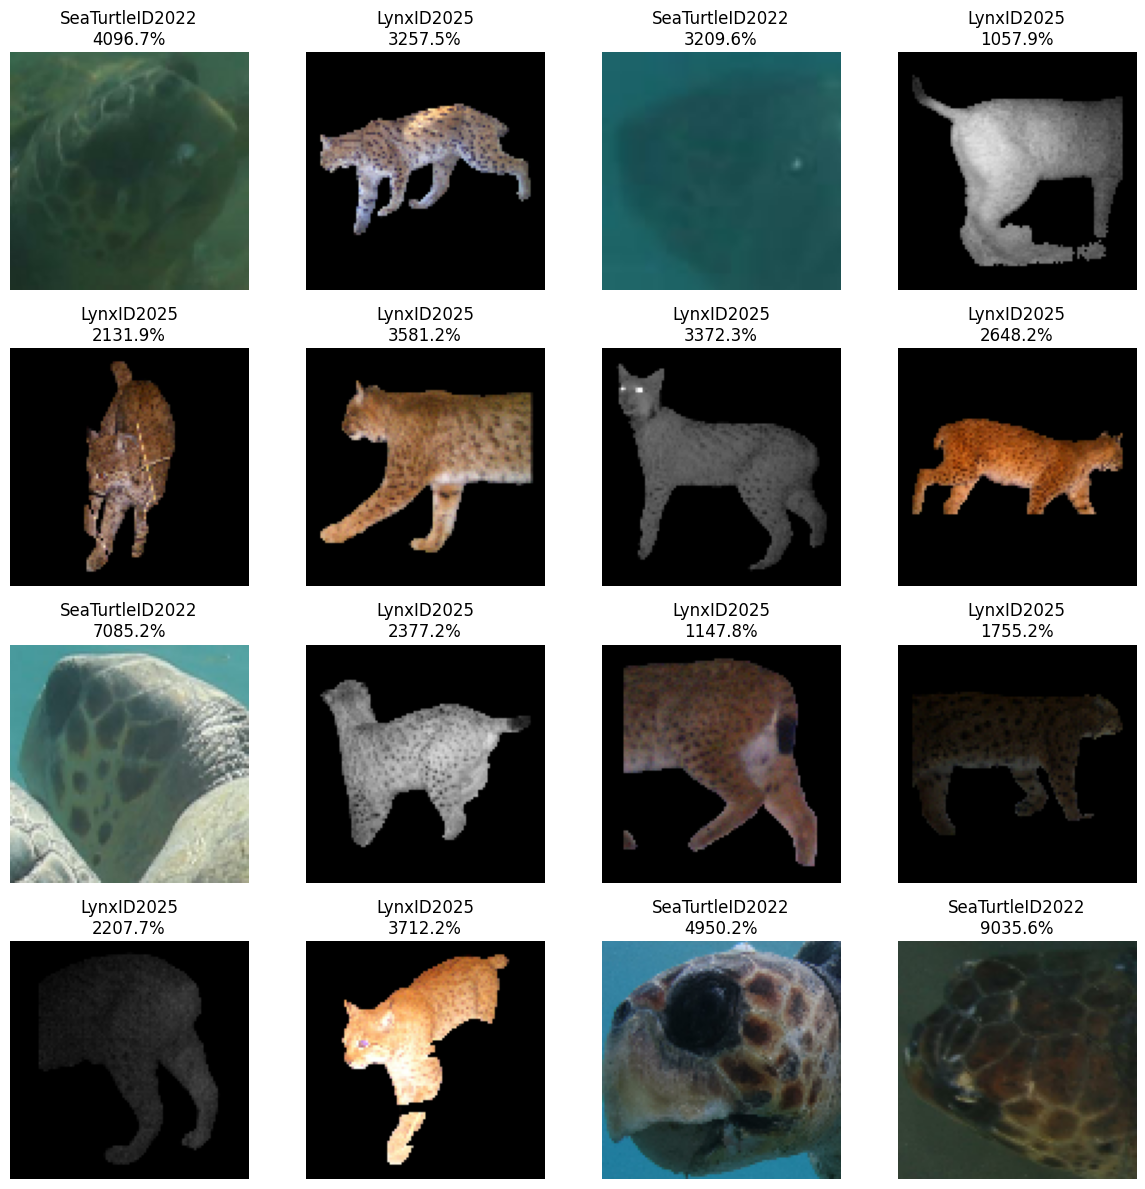

In [29]:
all_images = np.concatenate([x for x, y in val_ds], axis=0)

# 3) Find the sample‑indices whose max‑score < threshold
outside_idxs = np.where(pred_scores > threshold)[0]

# 4) Plot the first N of them
N = min(16, len(outside_idxs))
cols = 4
rows = (N + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for plot_i, sample_i in enumerate(outside_idxs[:N]):
    img   = all_images[sample_i]
    label = class_names[pred_idxs[sample_i]]
    score = pred_scores[sample_i]
    
    # If you used preprocess_input, you may need to reverse it to see correct colors:
    #   img = img[..., ::-1]  # BGR→RGB
    #   img = img + [123.68, 116.779, 103.939]  # add ImageNet means
    #   img = np.clip(img, 0, 255).astype('uint8')
    
    axes[plot_i].imshow(img.astype('uint8'))
    axes[plot_i].set_title(f"{label}\n{score*100:.1f}%")
    axes[plot_i].axis('off')

# hide any unused axes
for ax in axes[N:]:
    ax.axis('off')

plt.tight_layout()
plt.show()